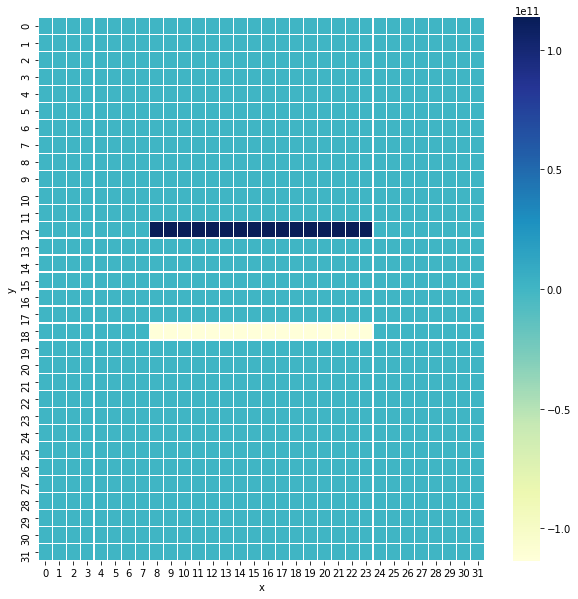

[[-3844.   961.     0. ...     0.     0.     0.]
 [  961. -3844.   961. ...     0.     0.     0.]
 [    0.   961. -3844. ...     0.     0.     0.]
 ...
 [    0.     0.     0. ... -3844.   961.     0.]
 [    0.     0.     0. ...   961. -3844.   961.]
 [    0.     0.     0. ...     0.   961. -3844.]]


In [152]:
#Import libraries
import numpy as np
import pylab as py
import seaborn as sns
import matplotlib.pyplot as plt
import time
import scipy

#Variables
N = 32
rho0 = 1
epsilon_0 = 8.8e-12

#Creating domain
x = np.linspace(0,1, N)
y = np.linspace(0,1, N)

#Creating lines of charge
dx = 1/(N-1)
dy = dx
p = np.zeros((N,N))

jmin = int(0.25/dx)+1
jmax = int(0.75/dx)+1
i2 = int(0.6/dy)
i1 = int(0.4/dy)
for j in range(jmin, jmax):
        p[i2, j] = -rho0/epsilon_0
        p[i1, j] = rho0/epsilon_0

ex = dx**(-2)
ey = ex

#Visualizing the lines of charge and the domain
plt.figure (figsize = (10,10))
ax = sns.heatmap(p, linewidth=0.1, cmap = "YlGnBu")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#Reindexing
#New rho 
pk = np.zeros ((N*N))
for i in range (N):
    for j in range (N):
        pk [i*N+j] = p [i,j]

#Matrix of coefficients
coef = np.zeros((N**2,N**2))

for k in range (N*N):
    coef [k,k] = -2*(ex+ey)
    if k-1 >= 0:
        coef [k,k-1] = ey
    if k+1 < (N*N):
        coef [k,k+1] = ey
    if k-N >=0 : 
        coef [k,k-N] = ex
    if k+N< (N*N): 
        coef [k,k+N] = ex
        
print(coef)

In [153]:
def Dirichlet(A):  # ces conditions conduisent à mettre à zéros certains termes de A (qui sont des facteurs des uk concernés)
   for k in range (N*N):
       i,j = k//N,k%N
       # sur le côté gauche i = 0
       if i == 0:
           #facteur de k-N nul
           if k-N>=0:
               A[k,k-N] = 0
       # sur le côté droit i = N-1
       if i == N-1:
           if k+N < N*N:
               A[k,k+N] = 0

       # sur le coté bas j = 0  
       if (j==0):
           if k-1>=0:
               A[k,k-1] = 0
       # sur le côté haut j = N-1
       if j == N-1:
           if k+1<N*N:             
               A[k,k+1] = 0

   return A

coef = Dirichlet(coef)
print(coef)

[[-3844.   961.     0. ...     0.     0.     0.]
 [  961. -3844.   961. ...     0.     0.     0.]
 [    0.   961. -3844. ...     0.     0.     0.]
 ...
 [    0.     0.     0. ... -3844.   961.     0.]
 [    0.     0.     0. ...   961. -3844.   961.]
 [    0.     0.     0. ...     0.   961. -3844.]]


In [132]:
start_np = time.time()
grand_u = np.linalg.solve(coef,pk)
end_np = time.time()
np_time = end_np-start_np
print(np_time)
pot_u = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        pot_u[i,j] = grand_u[i*N+j]

0.7964022159576416


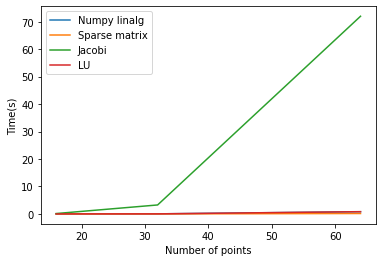

In [146]:
t_np = np.array([0.0009982585906982422,0.02693772315979004,0.7964022159576416])
t_sparse = np.array([0.002992868423461914,0.011964082717895508,0.14734625816345215])
t_jacobi = np.array([0.14024019241333008,3.2626185417175293,71.98724794387817])
t_lu = np.array([0.0018117427825927734,0.025008201599121094,0.8239891529083252])
numbers = np.array([16,32,64])

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(numbers,t_np,label='Numpy linalg')
ax1.plot(numbers,t_sparse,label='Sparse matrix')
ax1.plot(numbers,t_jacobi, label='Jacobi')
ax1.plot(numbers,t_lu,label='LU')
plt.xlabel('Number of points')
plt.ylabel('Time(s)')
plt.legend()
plt.show()

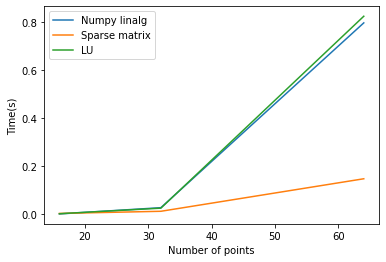

In [147]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(numbers,t_np,label='Numpy linalg')
ax1.plot(numbers,t_sparse,label='Sparse matrix')
ax1.plot(numbers,t_lu,label='LU')
plt.xlabel('Number of points')
plt.ylabel('Time(s)')
plt.legend()
plt.show()

In [133]:
start_sparse = time.time()
coef_sparse = scipy.sparse.csc_matrix(coef)
u_sparse = scipy.sparse.linalg.spsolve(coef_sparse,pk)
end_sparse = time.time()
sparse_time = end_sparse-start_sparse
print(sparse_time)
pot_sparse = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        pot_sparse[i,j] = u_sparse[i*N+j]

0.14734625816345215


In [157]:
def Jacobi(A, b, N, x_init): 
    init = time.time()
    D = np.diag(A)
    R = A - np.diagflat(D)
    for i in range(N):
        x = (b - R.dot(x_init))/D
        x_init = x
    end = time.time()
    elapsed = end-init
    return x, elapsed

u_jacobi, t_jacobi = Jacobi (coef, pk, int(1e4), np.zeros(len(pk)))
print(t_jacobi)

4.1002984046936035


In [135]:
from scipy.linalg import lu_factor, lu_solve
start_lu = time.time()
lu, piv = lu_factor(coef)
u_lu = lu_solve((lu,piv),pk)
end_lu = time.time()
lu_time = end_lu-start_lu
print(lu_time)
pot_lu = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        pot_lu[i,j] = u_lu[i*N+j]

0.8239891529083252


In [159]:
pot_jacobi = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        pot_jacobi[i,j] = u_jacobi[i*N+j]
print(t_jacobi)

4.1002984046936035


Text(0.5, 1.0, '$\\nabla^2 u = -\\rho/\\epsilon_0$')

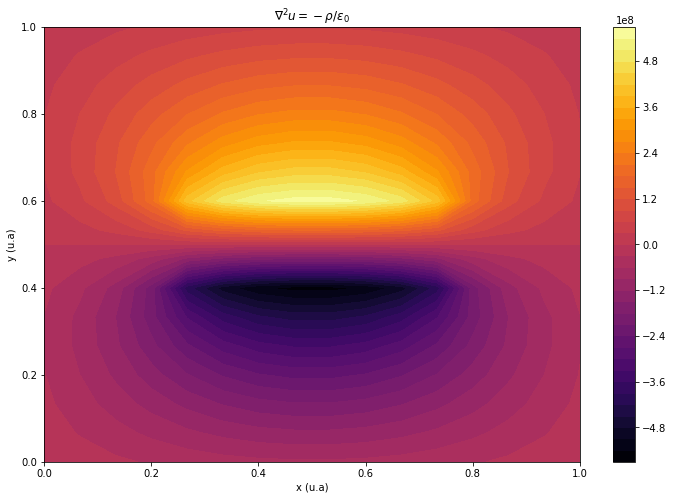

In [102]:
py.figure(figsize = (12,8))
py.contourf(x,y,pot_lu, 40, cmap = 'inferno')
py.colorbar()
py.xlabel('x (u.a)')
py.ylabel('y (u.a)')
py.title(r'$\nabla^2 u = -\rho/\epsilon_0$')

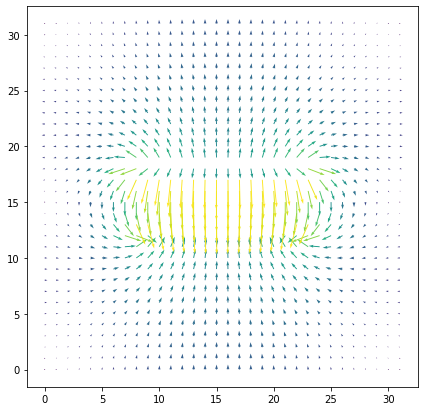

In [160]:
import matplotlib

u = -np.gradient(pot_jacobi,axis=0)
v = -np.gradient(pot_jacobi,axis=1)
n = -2

# Defining color
color_array = np.sqrt((abs((u-n))/2)*2 + (abs((v-n))/2)*2)

fig, ax = plt.subplots(figsize=(7,7))
ax.quiver(v,u,color_array)
plt.show()